# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
9. Pipeline section
10. Video Output


## To Check overall picture of the project you can directly check the pipeline section that explain everything

### 1. compute the camera calibration using chessboard images
#### Below cell calculate the object and image points

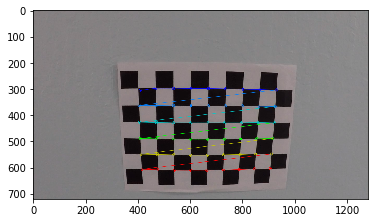

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,0,0),...(7,4,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        


#### undistort()
        function is used to undistort the distorted image

In [2]:
def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvec, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx,dist, None, mtx)
    
    return undist

### 2. Applying a distortion correction to all given test images

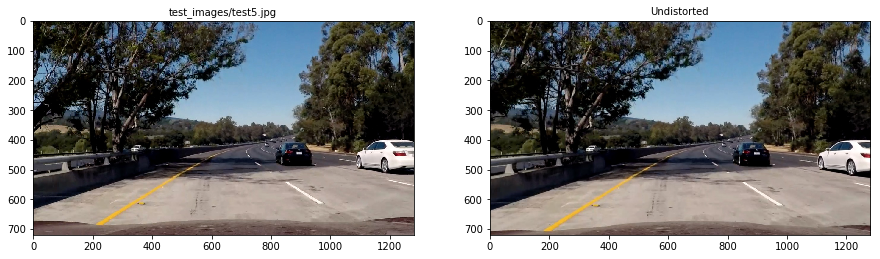

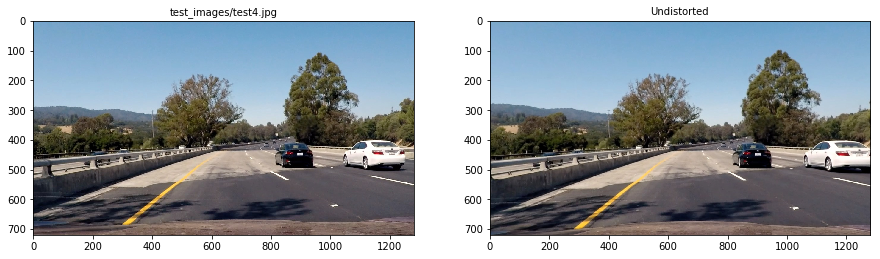

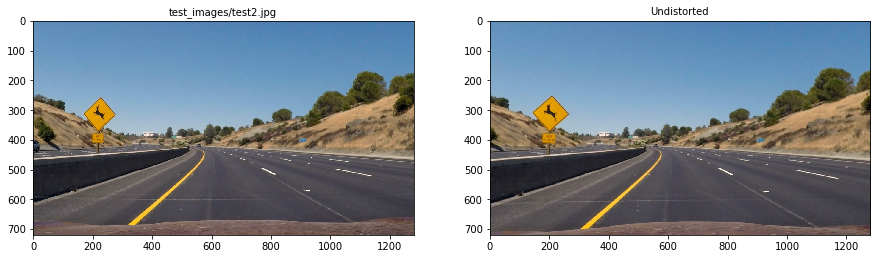

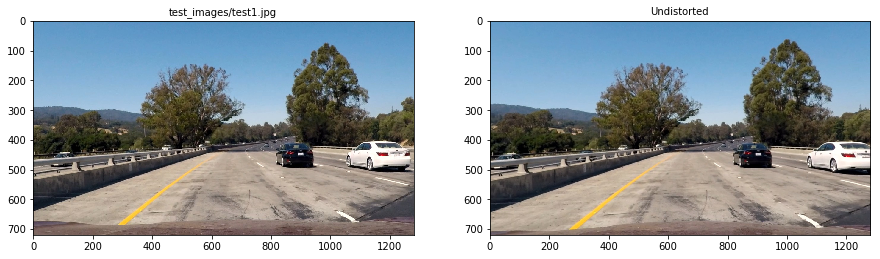

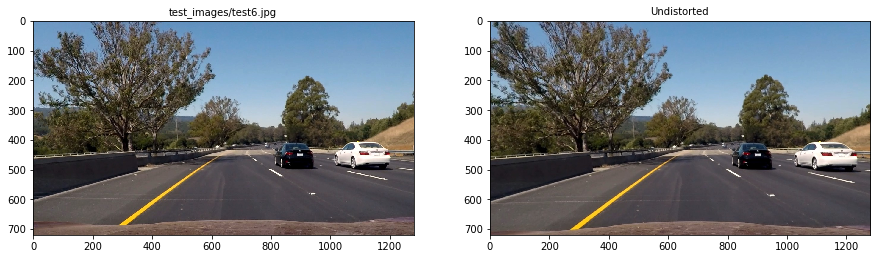

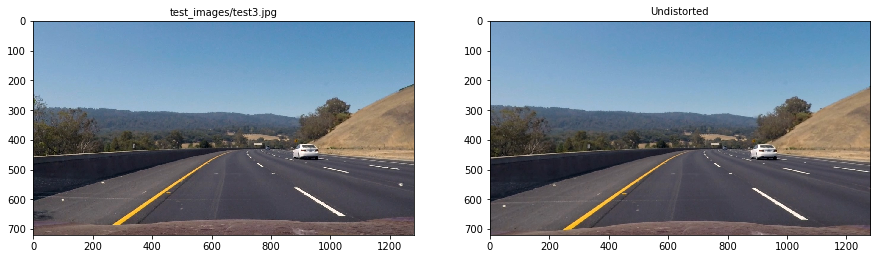

In [3]:
images = glob.glob('test_images/test*.jpg')

for image in images:
    img = mpimg.imread(image)
    undistimg = undistort(img,objpoints,imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.imshow(img)
    ax1.set_title(image, fontsize=10)
    ax2.imshow(undistimg)
    ax2.set_title('Undistorted', fontsize=10)

#### Here i am figuring out two color spaces RGB & HLS by displaying images in those color channels
#### Which gives me the clear picture which color channel is better
#### Applying with all the test images

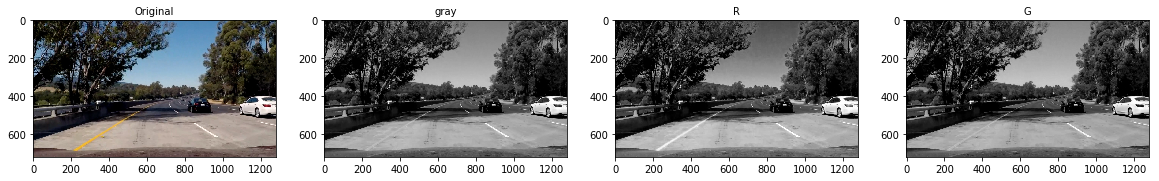

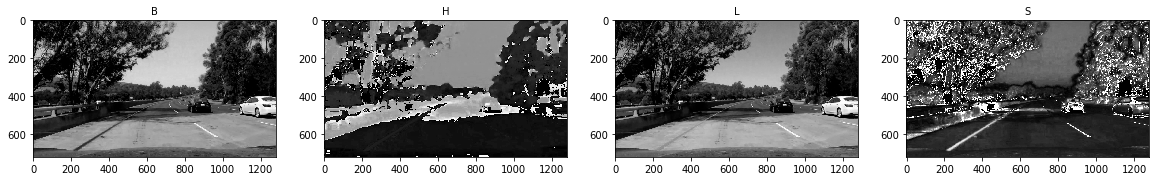

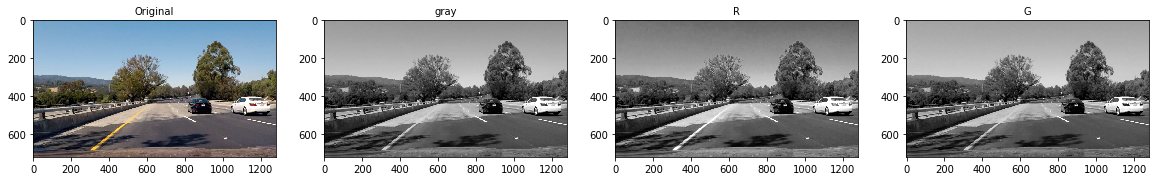

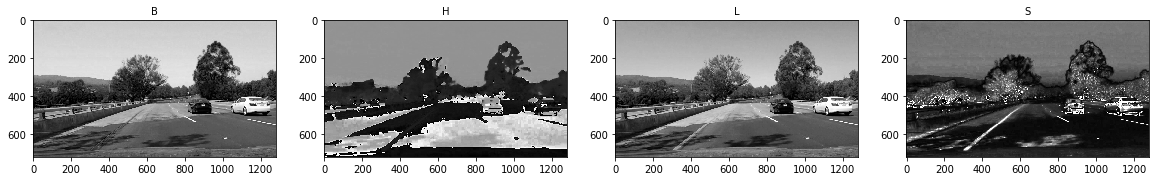

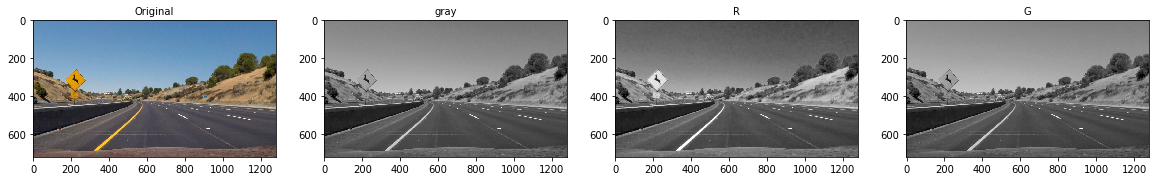

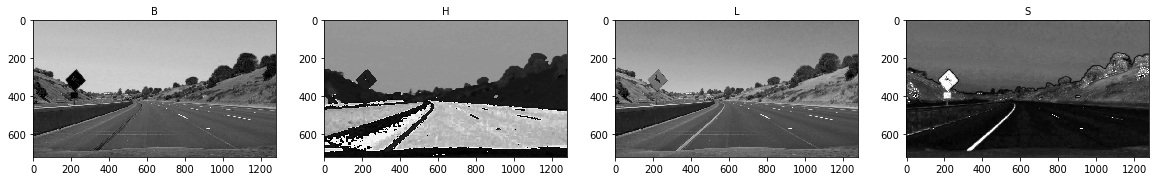

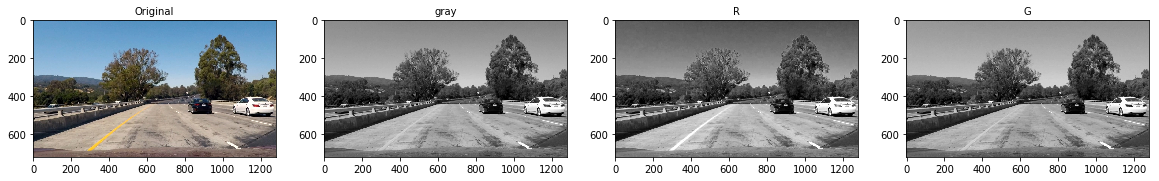

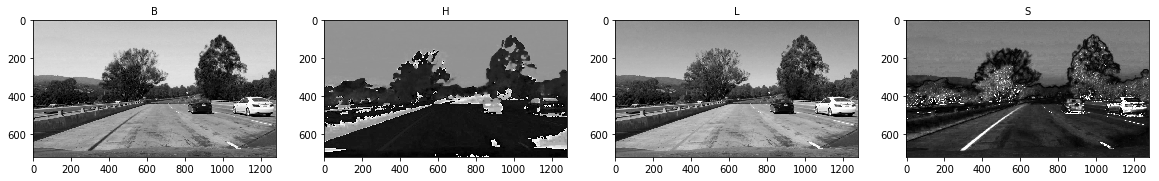

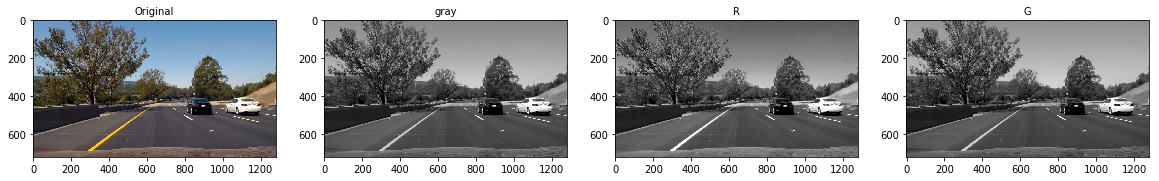

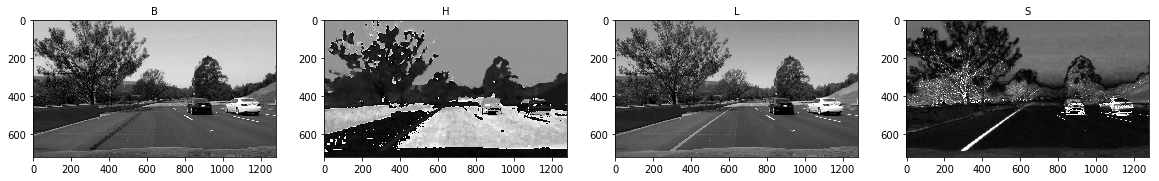

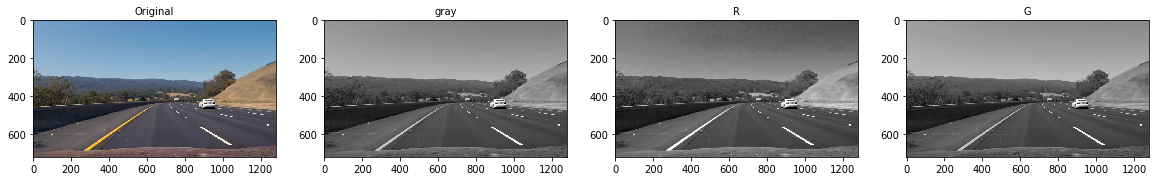

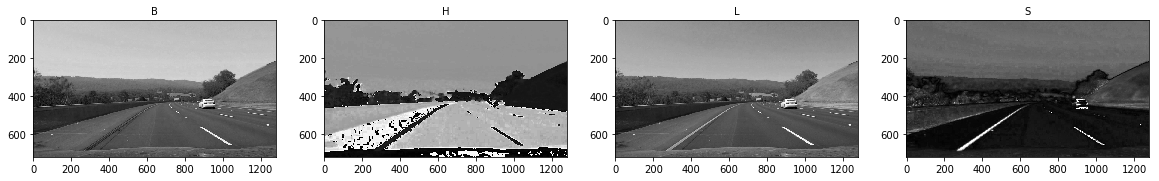

In [4]:
for image in images:
    img = mpimg.imread(image)
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    f, (org_img, gray_img , r , g ) = plt.subplots(1, 4,figsize=(20,10))
    org_img.imshow(img)
    org_img.set_title('Original', fontsize=10)
    gray_img.imshow(gray, cmap='gray')
    gray_img.set_title('gray', fontsize=10)
    r.imshow(R,cmap='gray')
    r.set_title('R', fontsize=10)
    g.imshow(G,cmap='gray')
    g.set_title('G', fontsize=10)
    f, (b, h , l , s ) = plt.subplots(1, 4,figsize=(20,10))
    
    b.imshow(B,cmap='gray')
    b.set_title('B', fontsize=10)
    h.imshow(H,cmap='gray')
    h.set_title('H', fontsize=10)
    l.imshow(L,cmap='gray')
    l.set_title('L', fontsize=10)
    s.imshow(S,cmap='gray')
    s.set_title('S', fontsize=10)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

#### binary_img()
        function is used to convert a raw image into a binary threshold image
        Here i used s color channel from HLS color space and sobelx gradient to find the binary threshold image

In [5]:
def binary_img(img,s_thresh=(170,255),sx_thresh=(50,100),sobel_kernel=3,display=False):
    img = np.copy(img)
    
    #R = img[:,:,0]
    #convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #sobel x
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    #sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    #abs_sobelxy = np.sqrt(sobelx*sobelx+sobely*sobely)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #print(np.max(scaled_sobel))
    #print(np.min(scaled_sobel))
    #r channel threshold binary
    #rbinary = np.zeros_like(R)
    #rbinary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    #s channel thershold binary
    sbinary = np.zeros_like(S)
    sbinary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    #x gradient threshold binary
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
          
    #color stacked binary
    color_stacked_binary = np.dstack((np.zeros_like(sxbinary),sbinary,sxbinary))*255
        
    #Combined threshold binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sbinary==1) | (sxbinary==1)] = 1
    
    if(display==True):
        f, (org_img, gray_img, s , sbin, sxbin) = plt.subplots(1, 5,figsize=(20,10))
        org_img.imshow(img)
        org_img.set_title('Original', fontsize=10)
        gray_img.imshow(gray, cmap='gray')
        gray_img.set_title('gray', fontsize=10)
        s.imshow(S, cmap='gray')
        s.set_title('S', fontsize=10)
        #r.imshow(R, cmap='gray')
        #r.set_title('R', fontsize=10)
        #rbin.imshow(rbinary, cmap='gray')
        #rbin.set_title('rbinary', fontsize=10)
        sbin.imshow(sbinary, cmap='gray')
        sbin.set_title('sbinary', fontsize=10)
        sxbin.imshow(sxbinary, cmap='gray')
        sxbin.set_title('sxbinary', fontsize=10)
        f, (color_bin, combined_bin ) = plt.subplots(1, 2,figsize=(20,10))
        color_bin.imshow(color_stacked_binary, cmap='gray')
        color_bin.set_title('Color stacked binary', fontsize=10)
        combined_bin.imshow(combined_binary, cmap='gray')
        combined_bin.set_title('Combined binary', fontsize=10)

    
    return combined_binary
    
    

#### Below cell displays how the binary_img function works on 1 image

array([[0, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 1, 0]], dtype=uint8)

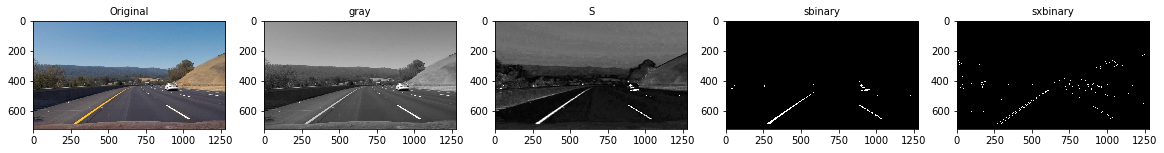

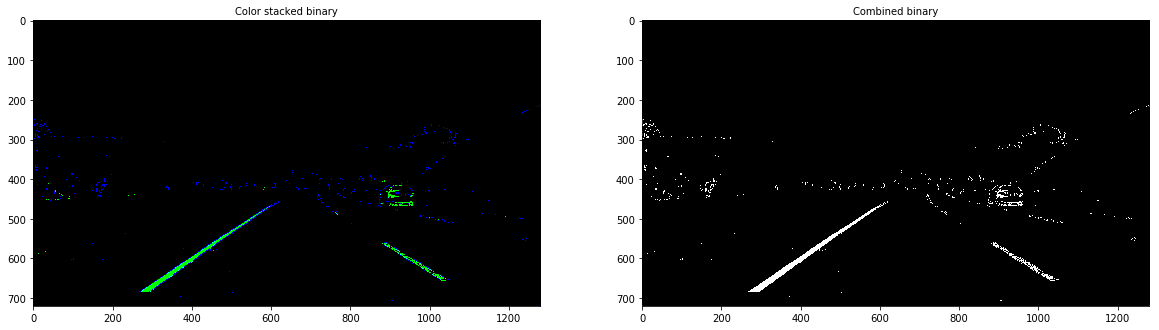

In [6]:
img = mpimg.imread(image)
binary_img(img,display=True)

#### Applying the binary_img() function on all the test images

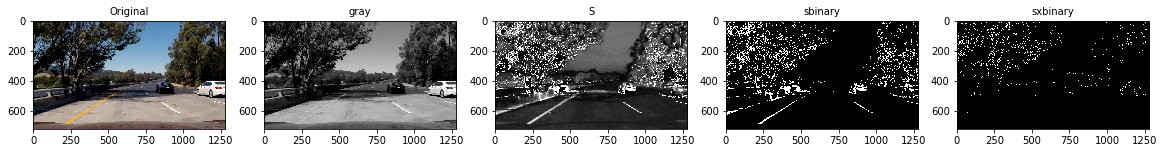

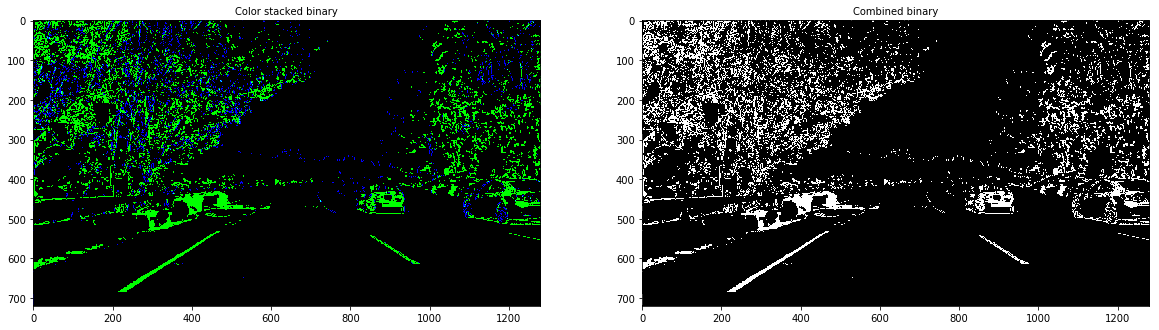

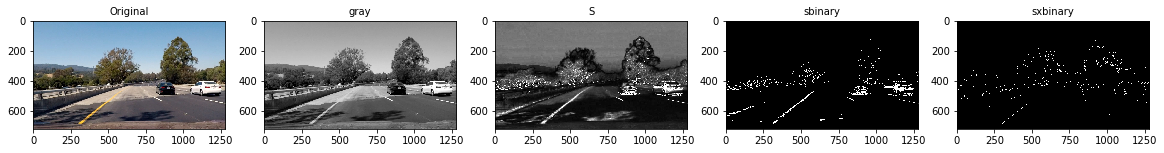

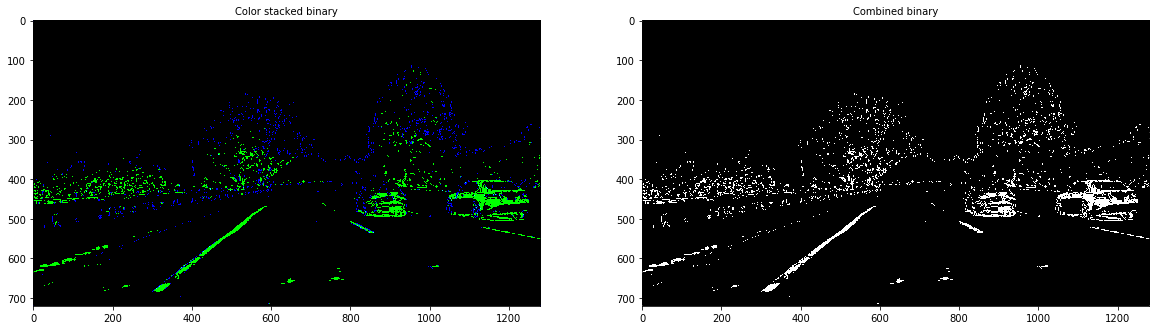

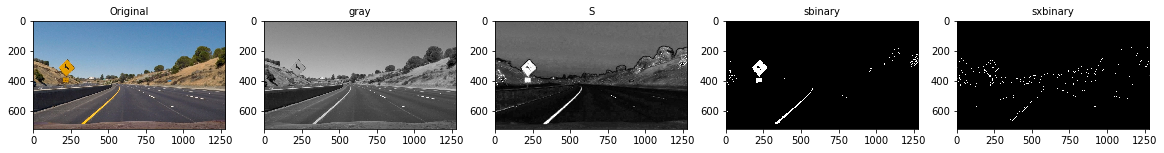

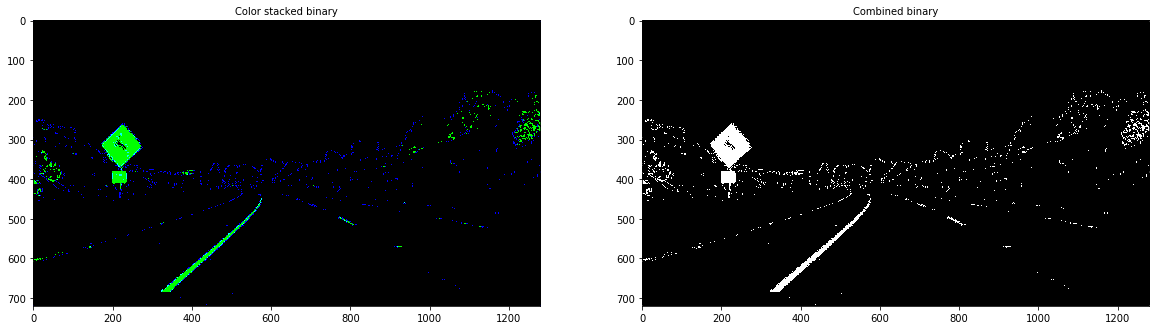

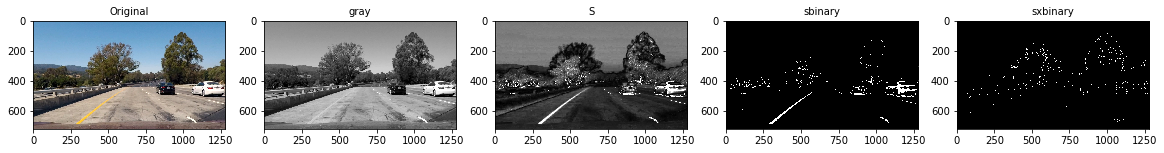

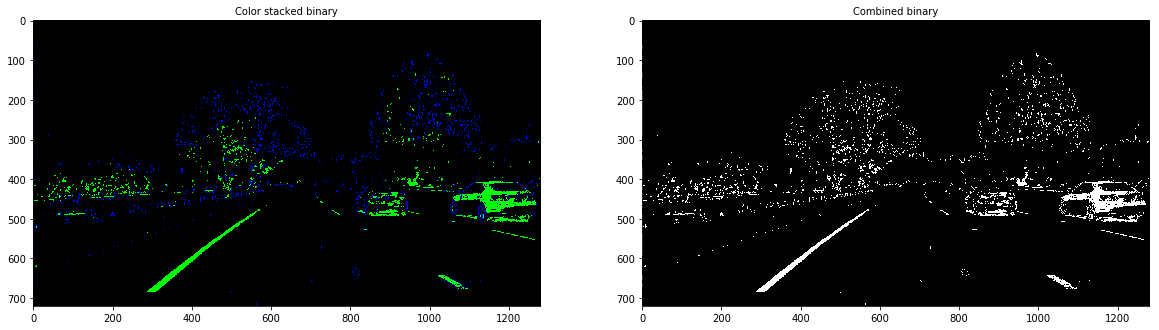

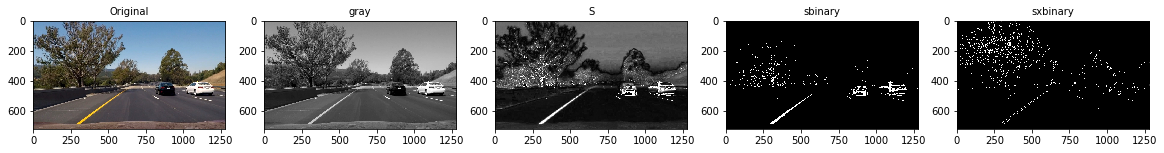

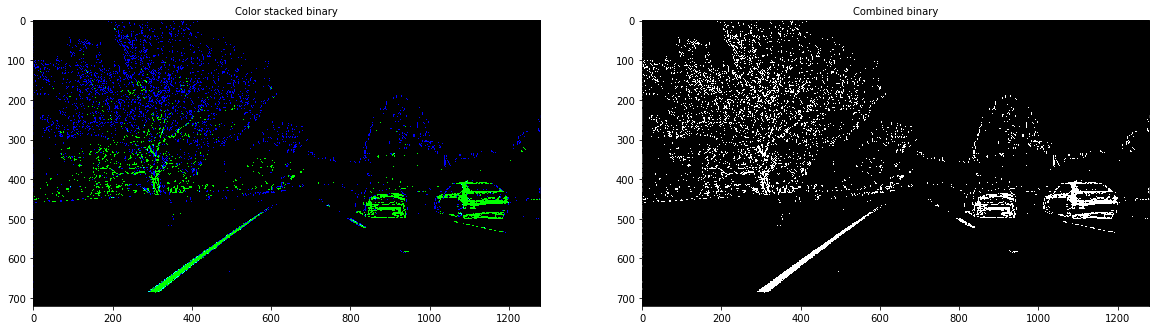

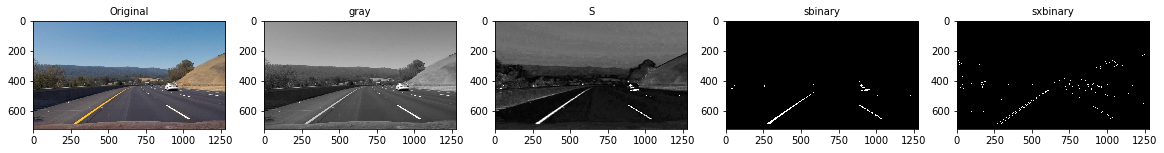

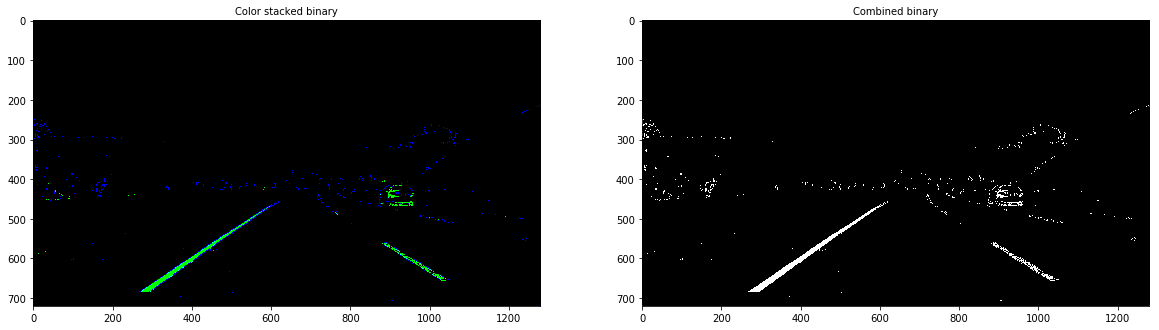

In [7]:
for image in images:
    img = mpimg.imread(image)
    binary_img(img,display=True)

#### region_of_interest()
        function is used to apply a filtered mask on binary threshold image and return the image only with lane lines

In [8]:
def region_of_interest(img, vertices):
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


#### Applying region_of_interest() function on all the given test images

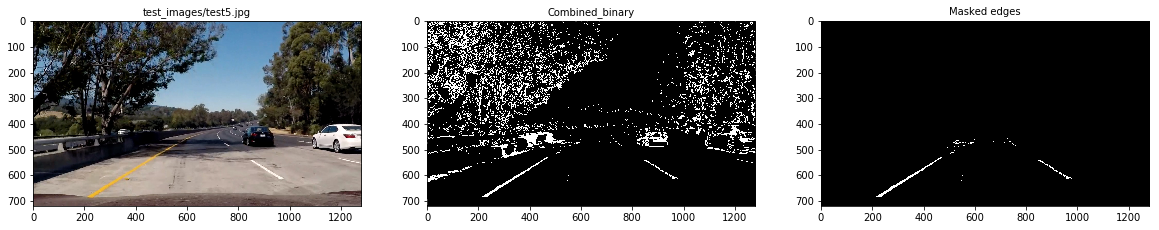

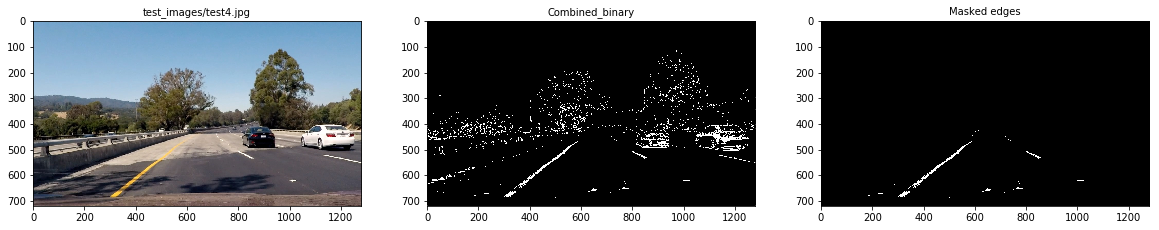

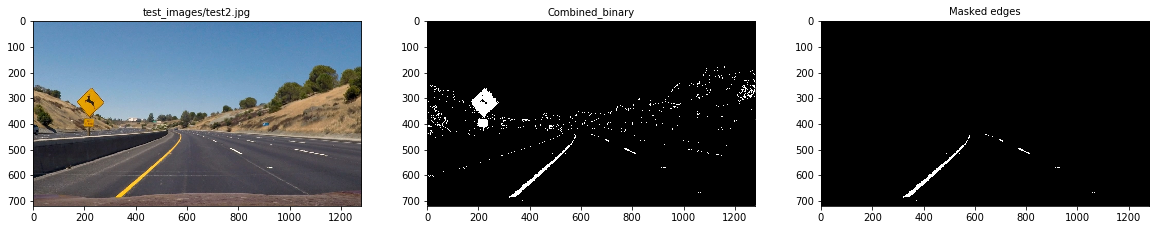

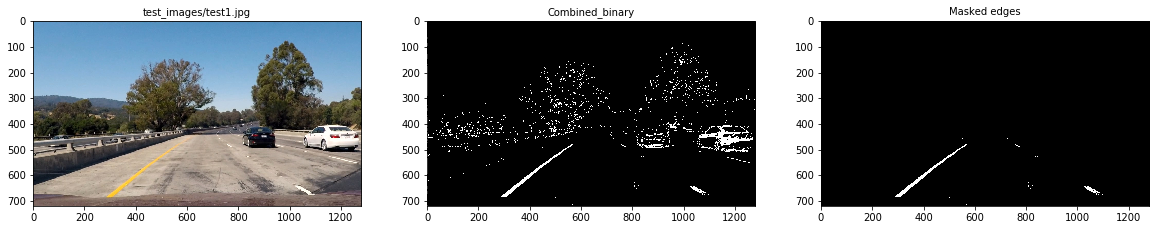

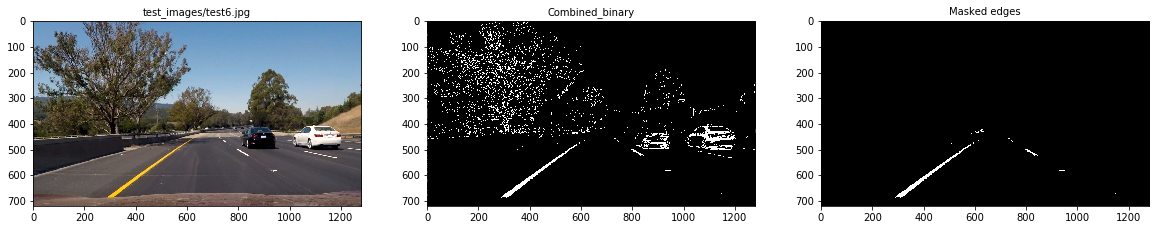

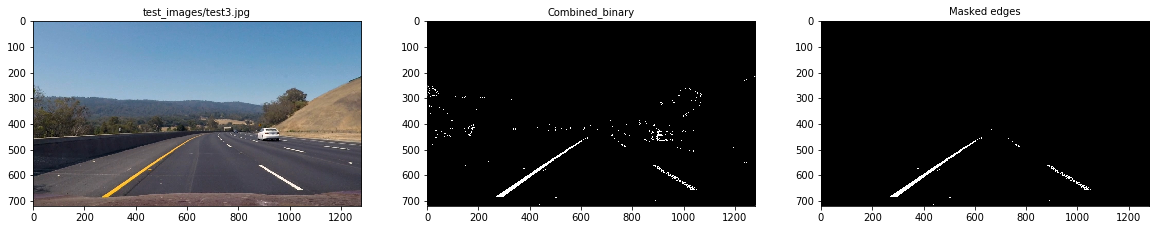

In [9]:
for image in images:
    img = mpimg.imread(image)
    imshape=img.shape
    combined_binary = binary_img(img)
    #combined_binary = binary_img(img,r_thresh=(170,255),s_thresh=(80,150),sx_thresh=(50,100),sobel_kernel=5)
    masked_edges = region_of_interest(combined_binary,np.array([[(0,imshape[0]),(imshape[1]//2-20,imshape[0]//2+60),(imshape[1]//2+20,imshape[0]//2+60),(imshape[1],imshape[0])]],dtype=np.int32))
    #masked_edges = region_of_interest(combined_binary,np.array([[(0,imshape[0]),(imshape[1]//2-20,imshape[0]//2+130),(imshape[1]//2+20,imshape[0]//2+130),(imshape[1],imshape[0])]],dtype=np.int32))
    f, (org_img, combined_bin, masked_img) = plt.subplots(1, 3,figsize=(20,10))
    org_img.imshow(img)
    org_img.set_title(image, fontsize=10)
    combined_bin.imshow(combined_binary, cmap='gray')
    combined_bin.set_title('Combined_binary', fontsize=10)
    masked_img.imshow(masked_edges, cmap='gray')
    masked_img.set_title('Masked edges', fontsize=10)

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

#### warp()
        function is used to change the perspective of the image
        Here i am using this warp() function to convert masked binary threshold image to warp birds-eye view image

In [10]:
def warp(img):
    
    imshape=img.shape
    img_size=(imshape[1],imshape[0])
    #Four source coordinate
    #src = np.float32([
    #    [0,imshape[0]],
    #    [imshape[1],imshape[0]],
    #    [imshape[1]//2-280,imshape[0]//2+110],
    #    [imshape[1]//2+250,imshape[0]//2+110]])
    
    src = np.float32([
        [0+130,imshape[0]],
        [imshape[1]-80,imshape[0]],
        [imshape[1]//2-90,imshape[0]//2+110],
        [imshape[1]//2+100,imshape[0]//2+110]])
    
    #Four dst coordinate
    dst = np.float32([
        [0+250,imshape[0]],
        [imshape[1]-300,imshape[0]],
        [0+250,0],
        [imshape[1]-300,0]])
    
    #Computing the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    #create warped image
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped

#### unwarp()
        function is used to apply the inverse perspective and convert it into original image

In [11]:
def unwarp(img):
    
    imshape=img.shape
    img_size=(imshape[1],imshape[0])
    #Four source coordinate
    #src = np.float32([
    #    [0,imshape[0]],
    #    [imshape[1],imshape[0]],
    #    [imshape[1]//2-280,imshape[0]//2+110],
    #    [imshape[1]//2+250,imshape[0]//2+110]])
    
    src = np.float32([
        [0+130,imshape[0]],
        [imshape[1]-80,imshape[0]],
        [imshape[1]//2-90,imshape[0]//2+110],
        [imshape[1]//2+100,imshape[0]//2+110]])
    
    #Four dst coordinate
    dst = np.float32([
        [0+250,imshape[0]],
        [imshape[1]-300,imshape[0]],
        [0+250,0],
        [imshape[1]-300,0]])
    
    #Computing the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    #create warped image
    unwarped = cv2.warpPerspective(img,Minv,img_size)
    
    return unwarped

#### Applying warp() function on all the given test images

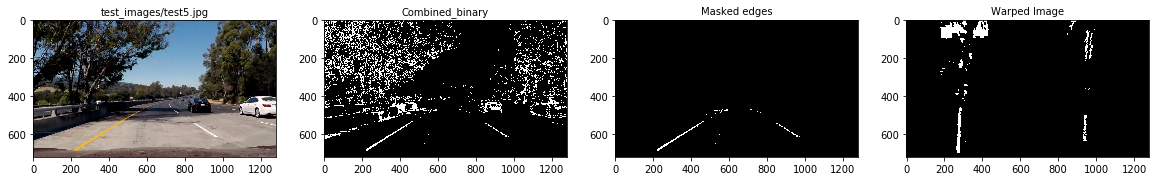

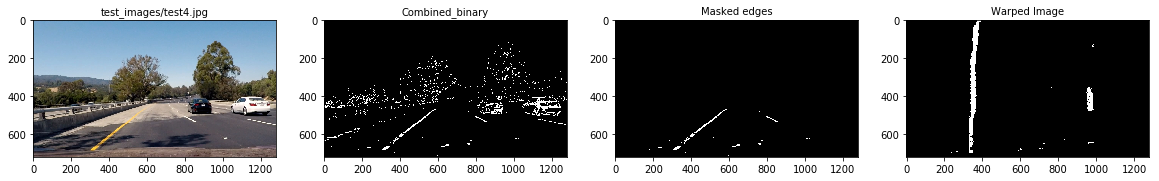

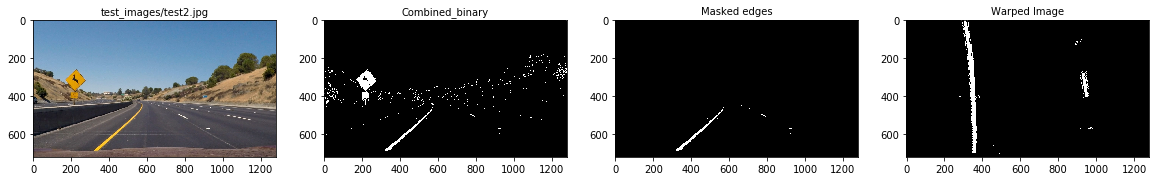

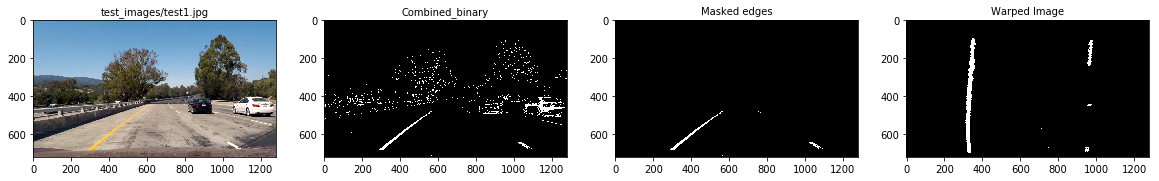

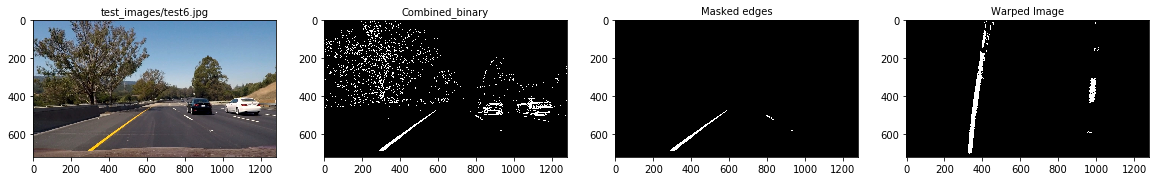

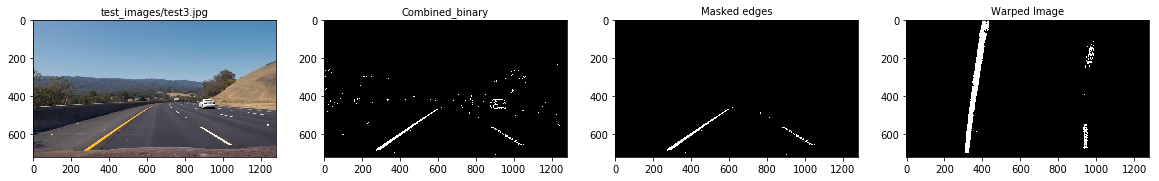

In [12]:
for image in images:
    img = mpimg.imread(image)
    imshape=img.shape
    combined_binary = binary_img(img)
    masked_edges = region_of_interest(combined_binary,np.array([[(0,imshape[0]),(imshape[1]//2-20,imshape[0]//2+70),(imshape[1]//2+20,imshape[0]//2+70),(imshape[1],imshape[0])]],dtype=np.int32))
    warped_img = warp(masked_edges)
    f, (org_img, combined_bin, masked_img,warped) = plt.subplots(1, 4,figsize=(20,10))
    org_img.imshow(img)
    org_img.set_title(image, fontsize=10)
    combined_bin.imshow(combined_binary, cmap='gray')
    combined_bin.set_title('Combined_binary', fontsize=10)
    masked_img.imshow(masked_edges, cmap='gray')
    masked_img.set_title('Masked edges', fontsize=10)
    #masked_img.plot(0+130,imshape[0]-10,'.')
    #masked_img.plot(imshape[1]//2-150,imshape[0]//2+110,'.')
    #masked_img.plot(imshape[1]//2+170,imshape[0]//2+110,'.')
    #masked_img.plot(imshape[1]-80,imshape[0]-10,'.')
    warped.imshow(warped_img,cmap='gray')
    warped.set_title('Warped Image',fontsize=10)



### 5. Detect lane pixels and fit to find the lane boundary.

#### find_lane_pixles()
        function is used to find the lane pixels on warped binary image

In [13]:
def find_lane_pixles(warped_img, display=False):
    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:],axis=0)
    out_img = np.dstack((warped_img,warped_img,warped_img))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:])+midpoint
    
    if(display==True):
        plt.plot(histogram)
        plt.plot(leftx_base,0,'.')
        plt.plot(rightx_base,0,'.')
    
    nwindows = 9
    margin = 100
    minipix = 50
    window_height = np.int(warped_img.shape[0]//nwindows)
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = warped_img.shape[0]-(window+1)*window_height
        win_y_high = warped_img.shape[0]-window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minipix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))            
        if len(good_right_inds) > minipix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



#### fit_polynomial()
        function is used to fit the polynomial after finding the lane pixels

In [14]:
def fit_polynomial(warped_img,display=False):
    leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img=warped_img)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    if(display==True):
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fitx,right_fitx,ploty,out_img

#### Below function shows how the fit_polynomial() function is working

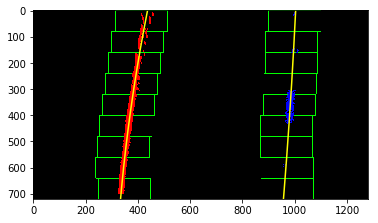

In [15]:
img = mpimg.imread("test_images/test6.jpg")
imshape=img.shape
combined_binary = binary_img(img)
masked_edges = region_of_interest(combined_binary,np.array([[(0,imshape[0]),(imshape[1]//2-20,imshape[0]//2+70),(imshape[1]//2+20,imshape[0]//2+70),(imshape[1],imshape[0])]],dtype=np.int32))
warped_img = warp(masked_edges)

#leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img)
left_fitx,right_fitx,ploty,out_img = fit_polynomial(warped_img)

plt.imshow(out_img)
plt.plot(left_fitx,ploty,color='yellow')
plt.plot(right_fitx,ploty,color='yellow')

### 6. Determine the curvature of the lane and vehicle position with respect to center.

#### measure_curvature_real()
        function is used to find the left and right curvature of the lane in meter

In [16]:
leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img)


def measure_curvature_real(leftx,lefty,rightx,righty):
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700

    ploty = np.linspace(0,719,720)

    left_fit = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
    right_fit = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
    
    y_eval = np.max(ploty)
    
    left_curvered = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5)/ np.absolute(2*left_fit[0])
    right_curvered = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    
    return left_curvered, right_curvered


#### cal_curvature_centeroffset()
        function is used to find the average curvature of the lane and vehicle position with repect to center

In [17]:
def cal_curvature_centeroffset(leftx,lefty,rightx,righty):
    
    xm_per_pix = 3.7/700
    left_curvered, right_curvered = measure_curvature_real(leftx,lefty,rightx,righty)
    avg_curve_rad = (left_curvered + right_curvered)/2
    
    #curvature_string = "Radius of curvature: %.2f m" % avg_curve_rad
    
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    height = warped_img.shape[0]

    left_fitx = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_fitx = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    # compute the offset from the center
    lane_center = (left_fitx + right_fitx)/2
    center_offset_pixels = (warped_img.shape[1]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    #offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    return avg_curve_rad,center_offset_mtrs

In [18]:
avg_curve_rad,center_offset_mtrs = cal_curvature_centeroffset(leftx,lefty,rightx,righty)
curvature_string = "Radius of curvature: %.2f m" % avg_curve_rad
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(curvature_string)
print(offset_string)

Radius of curvature: 4784.07 m
Center offset: -0.03 m


### 7. Warp the detected lane boundaries back onto the original image.

#### unwarped_binary_img_with_lane()
        function is used to unwarp the image with detected lane into masked binary image
        After applying this function we will get the masked binary image with detected lane

In [19]:
def unwarped_binary_img_with_lane(warped_binary_img,l_fit,r_fit):
    
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped_binary_img).astype(np.uint8)
       
    h,w = warped_binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = unwarp(color_warp)
    
    return unwarped

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### draw_lane()
        function is used to display the lane boundaries which we got from unwarped_binary_img_with_lane() function on original image
#### put_text_on_image()
        function is used to display the lane curvature and vehicle position on original image

Text(0.5,1,'Lane with data')

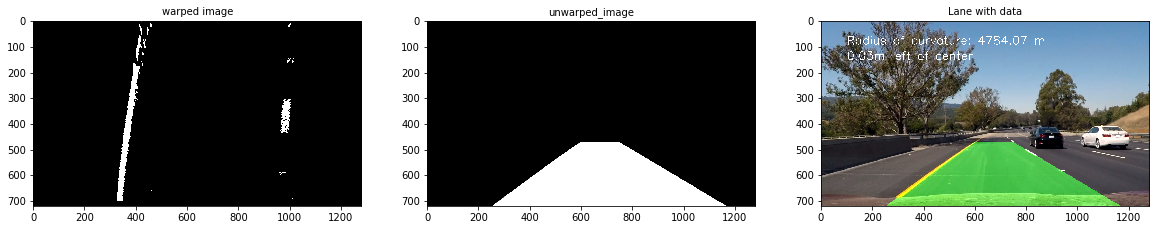

In [20]:
def draw_lane(original_img, unwarped):
    new_img = np.copy(original_img)
    
    un = np.dstack((unwarped,unwarped,unwarped))
    un_img = np.zeros_like(un)
    un_img[:,:,1][unwarped > 0]=255
    
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, un_img, 0.5, 0)
    return result

def put_text_on_image(image, avg_curve_rad, center_offset):
    new_img = np.copy(image)
    height = new_img.shape[0]
    
    curvature_string = 'Radius of curvature: {:05.2f} m'.format(avg_curve_rad)
    
    direction = ''
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'
    abs_center = abs(center_offset)
    offset_string = '{:04.2f}'.format(abs_center) + 'm ' + direction + ' of center'
    
    cv2.putText(new_img, curvature_string, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(new_img, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return new_img

leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img)
left_fit = np.polyfit(lefty,leftx,2)
right_fit = np.polyfit(righty,rightx,2)

unwarped_img = unwarped_binary_img_with_lane(warped_img, left_fit, right_fit)
l_image = draw_lane(img, unwarped_img)
avg_curve_rad,center_offset_mtrs = cal_curvature_centeroffset(leftx,lefty,rightx,righty)
final_lane_image = put_text_on_image(l_image,avg_curve_rad,center_offset_mtrs)

f, (w, u,ex) = plt.subplots(1, 3,figsize=(20,10))
w.imshow(warped_img,cmap='gray')
w.set_title('warped image', fontsize=10)
u.imshow(unwarped_img, cmap ='gray')
u.set_title('unwarped_image', fontsize=10)
ex.imshow(final_lane_image)
ex.set_title('Lane with data', fontsize=10)

### 9. Pipeline section

#### pipeline()
        function takes the original image and gives the final image with detected lane line and details displayed on the image
        This function has display arugment which display overall pipeline output when the value of the argument is True

In [21]:
def pipeline(imgfile, display=False):
    original_img = mpimg.imread(image)
    imshape=original_img.shape
    combined_binary = binary_img(original_img)
    masked_edges = region_of_interest(combined_binary,np.array([[(0,imshape[0]),(imshape[1]//2-20,imshape[0]//2+70),(imshape[1]//2+20,imshape[0]//2+70),(imshape[1],imshape[0])]],dtype=np.int32))
    warped_img = warp(masked_edges)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img=warped_img)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fitx,right_fitx,ploty,out_img = fit_polynomial(warped_img)
    
    unwarped_img = unwarped_binary_img_with_lane(warped_img, left_fit, right_fit)
    lane_img = draw_lane(original_img, unwarped_img)
    avg_curve_rad,center_offset_mtrs = cal_curvature_centeroffset(leftx,lefty,rightx,righty)
    final_image = put_text_on_image(lane_img,avg_curve_rad,center_offset_mtrs)
    
    if(display==True):
        f, (org_img, combined_bin, masked_img,warped,fitpoly,unwarped,lane) = plt.subplots(1, 7,figsize=(20,10))
        org_img.imshow(original_img)
        org_img.set_title(imgfile, fontsize=10)
        combined_bin.imshow(combined_binary, cmap='gray')
        combined_bin.set_title('Combined_binary', fontsize=10)
        masked_img.imshow(masked_edges, cmap='gray')
        masked_img.set_title('Masked edges', fontsize=10)
        warped.imshow(warped_img,cmap='gray')
        warped.set_title('Warped Image',fontsize=10)
        fitpoly.imshow(warped_img,cmap='gray')
        fitpoly.plot(left_fitx, ploty, color = 'yellow')
        fitpoly.plot(right_fitx, ploty, color = 'yellow')
        fitpoly.set_title('Fit poly image',fontsize=10)
        unwarped.imshow(unwarped_img,cmap='gray')
        unwarped.set_title('Unwarped Image',fontsize=10)
        lane.imshow(final_image)
        lane.set_title('Final Image',fontsize=10)
        
    return final_image

#### Applying pipeline() function on all the given test images
#### images during the pipeline process gives the clear picture how the pipeline works

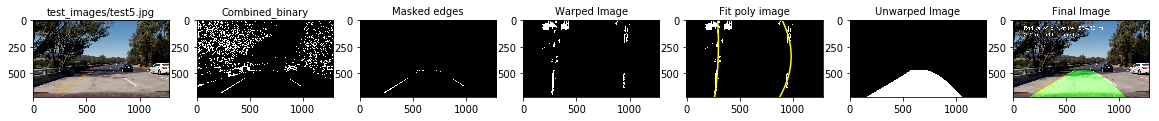

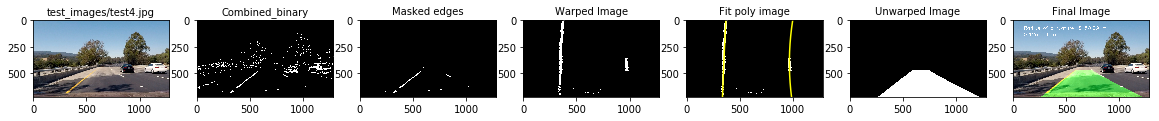

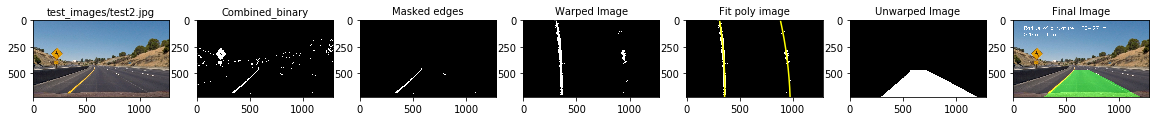

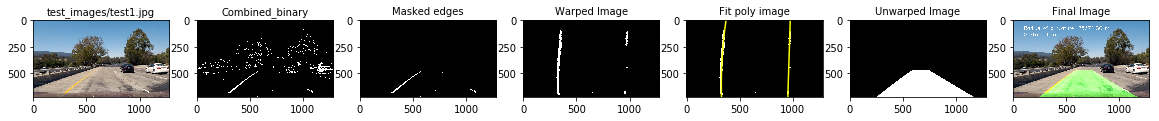

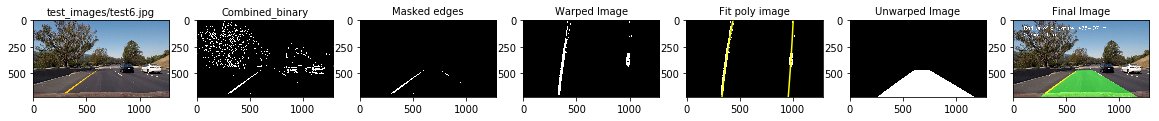

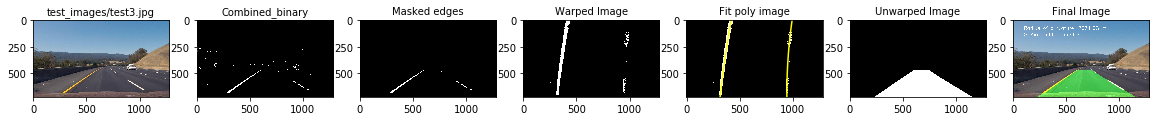

In [22]:
images = glob.glob('test_images/test*.jpg')

for image in images:
    pipeline(image,display=True)
    
#imgage = mpimg.imread("test_images/test2.jpg")
#pipeline(imgage,display=True)

### 10. Video Output
#### process_image()
        function performs the same operation as pipeline() function does
        i am using this function to detect lane on project_video

In [23]:
def process_image(image):
    imshape=image.shape
    combined_binary = binary_img(image)
    masked_edges = region_of_interest(combined_binary,np.array([[(0,imshape[0]),(imshape[1]//2-20,imshape[0]//2+70),(imshape[1]//2+20,imshape[0]//2+70),(imshape[1],imshape[0])]],dtype=np.int32))
    warped_img = warp(masked_edges)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixles(warped_img=warped_img)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    unwarped_img = unwarped_binary_img_with_lane(warped_img, left_fit, right_fit)
    lane_img = draw_lane(image, unwarped_img)
    avg_curve_rad,center_offset_mtrs = cal_curvature_centeroffset(leftx,lefty,rightx,righty)
    final_image = put_text_on_image(lane_img,avg_curve_rad,center_offset_mtrs)
    return final_image

#### Importing everything needed to edit/save/watch video clips

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Applying process_image() function on project_video.mp4

In [25]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:52<00:00,  4.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 15s, sys: 24.8 s, total: 2min 40s
Wall time: 4min 55s


#### Play the video inline

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))